IMPORTING THE REQUIRED LIBRARIES

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import explode
from pyspark.sql.functions import split

SETTING UP A SPARK SESSION TO HANDLE SQL CONTEXTS

In [2]:
spark = SparkSession \
    .builder \
    .appName("DB_SPARK_STREAM") \
    .getOrCreate()

CONFIGURING THE STREAMING PROTOCOLS TO LOCALHOST ON PORT 3000 

In [3]:
lines = spark \
    .readStream \
    .format("socket") \
    .option("host", "localhost")\
    .option("port", 3000) \
    .load()

SPLITTING THE STREAMS BY EMPTY SPACES 

In [4]:
words = lines.select(
   explode(
       split(lines.value, " ")
   ).alias("word")
)

REDUCING THE COLLECTED DATA BY GROUPING IDENTICAL WORDS AND RECORDING THE AMOUNT OF TIMES EACH GROUP OF WORDS APPEARS

In [5]:
wordCounts = words.groupBy("word").count()
lines.isStreaming

True

STARTING THE STREAM

In [6]:
query = wordCounts \
    .writeStream \
    .queryName("words")\
    .outputMode("complete")\
    .format("memory") \
    .start()

SLEEPING FOR 60 SECONDS TO LET THE DATA TO STREAM INTO THE SQL DATABASE

In [7]:
import time

In [8]:
import pandas as pd

In [9]:
from IPython import display
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
sns.set(style="whitegrid")

In [11]:
def PLOT_GRAPH(X,Y):
    try:
        plt.figure(figsize=(9,4))
        plt.title("Twitter words analysis")
        plt.xticks(rotation=40)
        plt.xlabel("Word Category")
        plt.ylabel("Amount of occurences in tweets")
        sns.barplot(X,Y)
        plt.show()
    except:
        pass
    
def PLOT_GRAPH_2(X,Y):
    try:
        plt.figure(figsize=(9,4))
        plt.title("Top 10 word appearances")
        plt.xticks(rotation=40)
        plt.xlabel("Word")
        plt.ylabel("Amount of occurences in tweets")
        sns.barplot(X,Y)
        plt.show()
    except:
        pass

IMPORTING THE OFFENSIVE LANGUAGE DETECTION LIBRARY (PROFANITY)

In [12]:
from profanity import profanity 
import string

IMPORTING AN ENGLISH DICTIONARY (ENCHANT) THIS LIBRARY HELPS DETECT AND PROVIDE SPELLING SUGGESTIONS 

In [13]:
import enchant
Spell = enchant.Dict("en_US")

TABULATE IS USED TO GENERATE A MISSPELT WORDS AND POSSIBLE SUGGESTIONS TABLE

In [14]:
from tabulate import tabulate

In [15]:
SPELLING_table = []
OFFENSIVE_TABLE = []
data = {}

THE DATA IS QUERIED FROM THE DATABASE AND GROUPED BY THE WORD COLUMN. THE RESULT IS CONVERTED TO A PANDAS DATAFRAME AND TRANSFORMED TO A DICTIONARY IN WHICH THE WORDS ARE THE KEYS

In [16]:
MISSPELT_WORDS=0
FOUL_LANGUAGE=0
CORRECTLY_SPELT_WORDS=0

In [17]:
COMMON_WORDS = []
COMMON_WORDS_Y = []
index = 0

In [18]:
time.sleep(60)
data.update(spark.sql("select * from words").toPandas().set_index('word').T.to_dict('list'))
data.pop('',None)

[66]

A GRAPH OF THE TOP 10 STREAMED WORDS WITHIN THE DATABASE ORDERED FROM THE HIGHEST OCCURENCE TO THE 10TH HIGHEST 

In [19]:
TOP_WORDS = sorted(data, key=data.get, reverse=True)[:10]
TOP_WORDS_Y = []
for i in TOP_WORDS:
    TOP_WORDS_Y.append(data[i][0])

THIS SECTION INCLUDES A TABLE OF ALL MISPELTS WORDS, A GRAPH COMPARING THE AMOUNT OF MISSPELT WORDS VS OFFENSIVE WORDS VS CORRECT WORDS, AND LASTLY A GRAPH OF THE MOST RECENTLY ANALYZED WORDS WITHIN THE CORRECT WORDS CATEGORY AND THE AMOUNT OF OCCURENCES THEY HAD WITHIN THE DATABASE 

In [20]:
print("ANALYZING...")
for key in data.keys():
    
        if(profanity.contains_profanity(key) == True):
            OFFENSIVE_TABLE.append([key])
            FOUL_LANGUAGE += data[key][0]
            continue
            
        elif(Spell.check(key)):
            CORRECTLY_SPELT_WORDS += data[key][0]
            continue
            
        elif(Spell.check(key) is False):
            MISSPELT_WORDS += data[key][0]
            CORRECTIONS = Spell.suggest(key)
            CORRECTIONS.insert(0,str(key))
            
            if(len(CORRECTIONS) > 4):CORRECTIONS = CORRECTIONS[0:4]
                
            SPELLING_table.append(CORRECTIONS)
print("COMPLETED RUN THE CELLS BELOW FOR RESULTS")

ANALYZING...
COMPLETED RUN THE CELLS BELOW FOR RESULTS


In [36]:
if(OFFENSIVE_TABLE):print(tabulate(OFFENSIVE_TABLE,headers=["OFFENSIVE WORD"],tablefmt="grid"))
with open("OFFENSIVE.txt","w") as file:
    file.write(tabulate(OFFENSIVE_TABLE,headers=["OFFENSIVE WORD"],tablefmt="grid"))

+------------------+
| OFFENSIVE WORD   |
+==================+
| SussexUni        |
+------------------+


In [32]:
if(SPELLING_table):
    print(tabulate(SPELLING_table,headers=["Missplelt Word","Suggestion 1","Suggestion 2","Suggestion 3"],tablefmt="grid"))
    with open("MISS-SPELLED WORDS TABLE.txt","w") as file:
        file.write(tabulate(SPELLING_table,headers=["Missplelt Word","Suggestion 1","Suggestion 2","Suggestion 3"],tablefmt="grid"))

+------------------------------+-------------------------------+-------------------------------+---------------------+
| Missplelt Word               | Suggestion 1                  | Suggestion 2                  | Suggestion 3        |
+==============================+===============================+===============================+=====================+
| bbybrandz                    | Brandyn                       | Brandy                        | brandy              |
+------------------------------+-------------------------------+-------------------------------+---------------------+
| presymptomatic               | asymptomatic                  | symptomatically               | symptomatic         |
+------------------------------+-------------------------------+-------------------------------+---------------------+
| qaangus                      | Angus                         | quangos                       | Ganges              |
+------------------------------+----------------

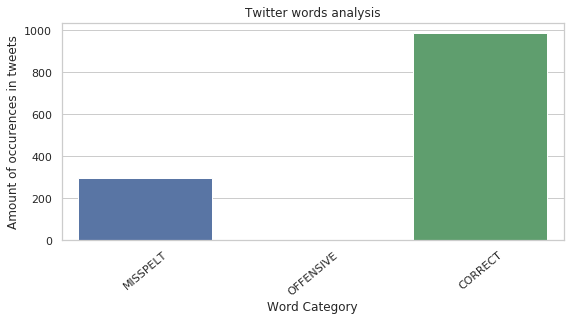

In [34]:
PLOT_GRAPH(["MISSPELT","OFFENSIVE","CORRECT"],[MISSPELT_WORDS,FOUL_LANGUAGE,CORRECTLY_SPELT_WORDS])

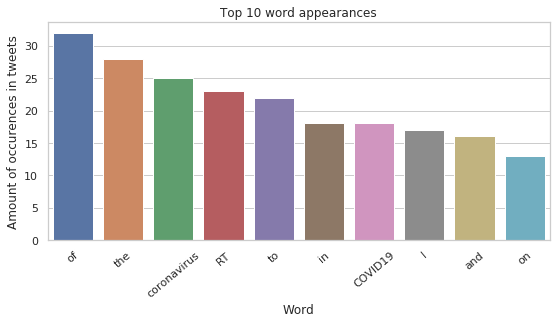

In [24]:
PLOT_GRAPH_2(TOP_WORDS,TOP_WORDS_Y)

In [28]:
print(len(data.keys()))

670
